## 데이터 로드

In [3]:
# Library
import pandas as pd
import numpy as np
import seaborn as sns
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import zipfile
import pickle
from io import TextIOWrapper
import matrixprofile as mp
from matrixprofile.visualize import plot_motifs_mp, plot_discords_mp
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
import hdbscan
import mass_ts as mts
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

import networkx as nx
from networkx.algorithms import bipartite

import sys
#sys.path.remove('/Users/soyoung/anaconda3/envs/mp/lib/python3.8/site-packages/')
sys.path.append('/Users/soyoung/workspace/event_graph/library/peak-over-threshold/src/') # spot.py path
sys.path.append('/Users/soyoung/workspace/event_graph/library/mass-ts/mass_ts/')         # _mass_ts_sy.py path
sys.path.append('/Users/soyoung/workspace/event_graph/library/twiter_tgn/')
sys.path.append('/Users/soyoung/workspace/event_graph/library/DyGLib/')

from spot_md import spot
from pot import pot
from spot_sy import spot_sy
from _mass_ts_sy import mass2 as mass2_sy

import random
random.seed(1127)

%matplotlib inline

In [4]:
# data load
def set_index_df(file_path, sheet_name):
    df = pd.read_excel(file_path, sheet_name = sheet_name, engine = 'openpyxl')
    df = df.drop(['Unnamed: 0', 'Total Consumption'], axis=1)
    df.set_index('Periods', inplace=True)
    df.index = pd.date_range(start='2023-01-01', periods=len(df), freq='15T')
    
    return df

new_directory = "/Users/soyoung/workspace/event_graph/data"
os.chdir(new_directory)

# Power consumption dataset
file_path = 'Dataset.xlsx'; sheet_name = 'PublicBuilding'
power = set_index_df(file_path, sheet_name)

power = power.drop(['AC4', 'Refrigerator'], axis=1)

## Event Graph 생성 

In [5]:
# functions
def matrix_profile_set(df, window_size, top_k):
    profiles_set = {}
    
    for col_name in df.columns:
        key = '{} Profile'.format(col_name)
        profiles_set[key] = mp.compute(df[col_name].values, window_size)
        profiles_set[key] = mp.discover.motifs(profiles_set[key],
                                               exclusion_zone = window_size//2,
                                               k = top_k)
            
    return profiles_set

def dtw_distance(x, y):
    distance, _ = fastdtw(x, y)
    return distance

def dtw_distance_matrix(time_series_list):
    num_series = len(time_series_list)
    distance_matrix = np.zeros((num_series, num_series))

    for i in range(num_series):
        for j in range(i, num_series):
            distance_matrix[i, j] = dtw_distance(time_series_list[i], time_series_list[j])
            distance_matrix[j, i] = distance_matrix[i, j]  # 대칭 행렬
            
    return distance_matrix

def event_generation_set(df, mp_set, window_size, cluster_size):
    motifs = {}
    for col_name in df.columns:
        key = '{} Profile'.format(col_name)
        index = [item['motifs'] for item in mp_set[key]['motifs']]                
        motifs[col_name] = list(set(sum(index, [])))                    # 중복 index 제외

    patterns = []
    for col_name in df.columns:
        patterns.append([df[col_name].values[idx : idx + window_size] for idx in motifs[col_name]])
    patterns = list({tuple(array) for array in sum(patterns, [])})      # 중복 제외
    patterns = [np.array(array) for array in patterns]


    hdb_cluster = hdbscan.HDBSCAN(metric = dtw_distance, min_cluster_size = cluster_size)
    hdb_cluster.fit(patterns)
    cls_labels = hdb_cluster.labels_
    
    events_list = []
    for i in np.unique(cls_labels)[np.unique(cls_labels) != -1]:
        events_list.append(hdb_cluster.weighted_cluster_centroid(cluster_id = i))
    #for i in list(np.where(cls_labels == -1)[0]):
    #    events_list.append(patterns[i])

    events_set = {}
    for i, event in enumerate(events_list):
        key = 'Event {}'.format(i + 1)
        events_set[key] = event 

    return events_set

def extract_windows_df(df, window_size, window_stride):
    
    num_windows = (len(df) - window_size) // window_stride + 1
    range_windows = range(0, num_windows * window_stride, window_stride)
    windows_df = pd.DataFrame(index = range_windows, columns =  df.columns)

    windows = []
    for col_name in df.columns:
        windows = []
        for i in range_windows:
            data = df[col_name][i : i + window_size].values
            windows.append(data.tolist())
        windows_df[col_name] = windows

    return windows_df

def pattern_matching_df(window_df, event_set):
    similarity_tensor = {}
    
    for i in window_df.index:
        sliding_window = window_df.loc[i]
        similarity = {}
        
        for col_name in window_df.columns:
            ts_similarity = []
            for event in event_set.values():
                ts_similarity.append(mass2_sy(sliding_window[col_name], event))
            similarity[col_name] = np.concatenate(ts_similarity)
            
        similarity_tensor[i] = similarity

    
    event_matching_df = pd.DataFrame(index = window_df.index, columns =  window_df.columns)
    
    for i in similarity_tensor.keys():
        similarity = similarity_tensor[i]
        for col_name in similarity.keys():
            event_matching_df[col_name][i] = 'Event {}'.format(np.nanargmin(similarity[col_name]) + 1)

    return event_matching_df

def extract_residual_windows_df(window_df, event_set, pattern_matching_df):
    residual_windows_df = pd.DataFrame(index = window_df.index, columns =  window_df.columns)

    for col_name in residual_windows_df.columns:
        for i in residual_windows_df.index:
            event_key = pattern_matching_df[col_name][i]
            residual_windows_df[col_name][i] = window_df[col_name][i] - event_set[event_key]

    return residual_windows_df

def extract_threshold_windows_df(df, window_df, window_length, window_stride, init_level = 0.8):
    threshold_df = pd.DataFrame(index = df.index, columns =  window_df.columns)

    for col_name in window_df.columns:
        if col_name in ('AC4', 'Refrigerator'):
            threshold_df[col_name] = [max(df[col_name])] * len(df[col_name])
        else:
            init = int(len(df)*0.9)
            threshold = spot_sy(df[col_name], num_init = init, init_level = init_level, risk = 1e-4)
            threshold_df[col_name] = threshold['t']

    threshold_windows_df = extract_windows_df(threshold_df, window_length, window_stride)
    
    return threshold_windows_df

def residual_matching_df(residual_window_df, threshold_window_df):
    residual_matching_df = pd.DataFrame(index = residual_window_df.index, columns =  residual_window_df.columns)

    for col_name in residual_matching_df.columns:
        for i in residual_matching_df.index:
            condition = np.any((residual_window_df[col_name][i] - threshold_window_df[col_name][i]) > 0) 
            if condition == True:
                residual_matching_df[col_name][i] = 'Residual +'
            else:
                residual_matching_df[col_name][i] = 'Residual -'
    
    return residual_matching_df

def event2graph_df(pattern_df, residual_df, evnet_set):
    time_series_node = list(pattern_df.columns)
    event_node = list(evnet_set.keys()) + ['Residual +', 'Residual -']  # residual error event node
    
    timeseries_mapping = {time_series: idx for idx, time_series in enumerate(time_series_node)}
    event_mapping = {event: idx for idx, event in enumerate(event_node)}
    
    pattern_matching_mapped = pattern_df.copy() 
    for column in pattern_df.columns:
        pattern_matching_mapped[column] = pattern_df[column].map(event_mapping)
    
    residual_matching_mapped = residual_df.copy() 
    for column in residual_df.columns:
        residual_matching_mapped[column] = residual_df[column].map(event_mapping)

    event_df = pd.melt(pattern_matching_mapped.reset_index(), id_vars = ['index'], var_name = 'u', value_name = 'i').rename(columns={'index': 'ts'})
    residual_df = pd.melt(residual_matching_mapped.reset_index(), id_vars = ['index'], var_name = 'u', value_name = 'i').rename(columns={'index': 'ts'})

    graph_df = pd.concat([event_df, residual_df], axis=0)
    graph_df = graph_df.reset_index()
    graph_df['label'] = 0.0  #state level
    graph_df = graph_df[['u', 'i', 'ts', 'label']]
    graph_df['u'] = graph_df['u'].map(timeseries_mapping)   # appiance mapping

    edge_features_df = pd.concat([pd.get_dummies(graph_df['u'], prefix='u', dtype=int),
                                  pd.get_dummies(graph_df['i'], prefix='i', dtype=int)], axis=1)
    graph_df = pd.concat([graph_df, edge_features_df], axis=1)
    graph_df = graph_df.sort_values(by=['ts', 'u'])
    graph_df = graph_df.reset_index(drop=True)

    return graph_df

In [6]:
# data shape
power.shape

(35136, 8)

In [7]:
# data shape change
df = power
print(df.shape)

(35136, 8)


In [8]:
# hyper-parameter
window_size = 4 * 3; window_stride = 4
motifs_k = 5; min_cluster_size = 2

In [9]:
# matrix profile
mp_set = matrix_profile_set(df, window_size, motifs_k)

In [10]:
# event generation
event_set = event_generation_set(df, mp_set, window_size, min_cluster_size)
print(len(event_set))

4


In [11]:
# window
window = extract_windows_df(df, window_size, window_stride)
print(len(window))

8782


In [12]:
# pattern node
pattern_node = pattern_matching_df(window, event_set)

In [13]:
# residual window
residual_window = extract_residual_windows_df(window, event_set, pattern_node)

In [14]:
# threshold window
threshold_window = extract_threshold_windows_df(df, window, window_size, window_stride)

In [15]:
# residual node
residual_node = residual_matching_df(residual_window, threshold_window)

In [26]:
event_map = list(event_set.keys()) + ['Residual +', 'Residual -']  # residual error event node
event_mapping = {event: idx for idx, event in enumerate(event_map)}

In [27]:
pattern_mapped = pattern_node.copy() 
for column in pattern_node.columns:
    pattern_mapped[column] = pattern_node[column].map(event_mapping)

residual_mapped = residual_node.copy() 
for column in residual_node.columns:
    residual_mapped[column] = residual_node[column].map(event_mapping)

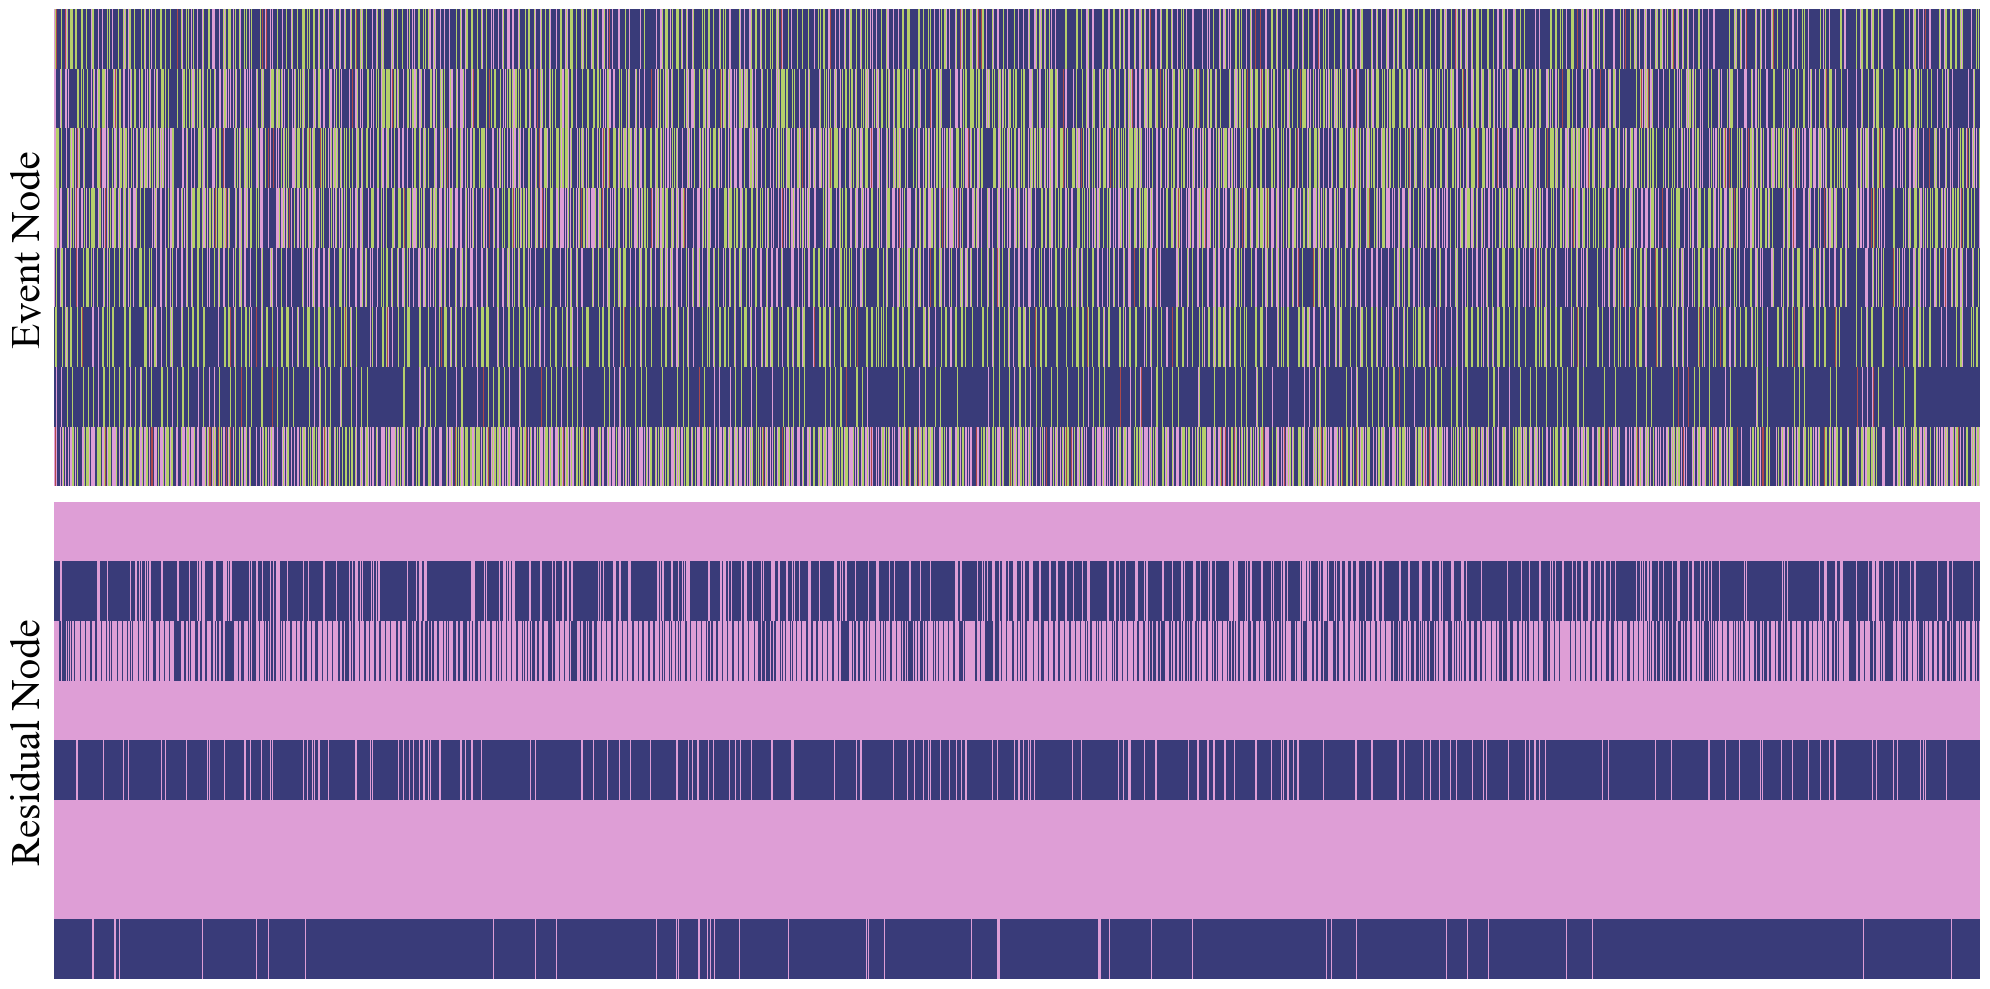

<Figure size 1920x1440 with 0 Axes>

In [65]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1) 
sns.heatmap(pattern_mapped.T, cmap='tab20b', cbar=False, xticklabels=False, yticklabels=False)
plt.ylabel('Event Node', fontsize=30)

plt.subplot(2, 1, 2) 
sns.heatmap(residual_mapped.T, cmap='tab20b_r', cbar=False, xticklabels=False, yticklabels=False)
plt.ylabel('Residual Node', fontsize=30)

# plt.text(0.5, 0.03, '(a) Traffic', ha='center', fontsize=40, transform=plt.gcf().transFigure)
plt.tight_layout()
plt.figure(dpi=300)
plt.show()

In [ ]:
# graph generation
graph = event2graph_df(pattern_node, residual_node, event_set)

In [ ]:
ls = list(graph['i'].unique()); ls.sort()
print(ls); print(len(ls))

In [16]:
# pattern graph extraction
pattern_graph = graph[::2]

In [18]:
ls = list(pattern_graph['i'].unique()); ls.sort()
print(ls); print(len(ls))

[0, 1, 2, 3]
4


## Graph save

In [19]:
# save the graph
new_directory = "/Users/soyoung/workspace/event_graph/library/DyGLib"; os.chdir(new_directory)

graph.to_csv('./DG_data/power_pr/power_pr.csv', sep = ',', index = False)
pattern_graph.to_csv('./DG_data/power_p/power_p.csv', sep = ',', index = False)

## Preprocessing

In [20]:
!python preprocess_data/preprocess_data.py --dataset_name power_pr
!python preprocess_data/preprocess_data.py --dataset_name power_p

preprocess dataset power_pr...
number of nodes  14
number of node features  172
number of edges  140512
number of edge features  14
power_pr is processed successfully.
preprocess dataset power_p...
number of nodes  12
number of node features  172
number of edges  70256
number of edge features  14
power_p is processed successfully.
